In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Phi, u, and v will be a 3D array with indices [l,m,n]
# Phi = u + i*v where i is the imaginary unit!

def tdse(u0, v0, m1, m2, dt, dx, T, V):
    '''
        u0 : LxM array, real part of the initial wave function
        v0 : LxM array, imaginary part of the initial wave function
        m1 : float,     mass of first particle
        m2 : float,     mass of second particle
        dt : float,     time step
        dx : float,     space step
        T  : float,     total simulation time
        V  : function,  ???
    '''
    
    # initialization
    L = u0.shape[0]
    M = u0.shape[1]
    N = int(T/dt)
    lmbd = dt/(dx**2)
    
    u = np.zeros((L,M,N+1))
    v = np.zeros((L,M,N+1))
    rho = np.zeros((L,M,2*(N+1))) #need to calculate first 4 values?
    u[:,:,0] = u0
    u[:,:,1] = u0
    v[:,:,0] = v0
    v[:,:,1] = v0
    la = np.arange(L)*dx
    ma = np.arange(M)*dx
    la, ma = np.meshgrid(la, ma)
    Va = V(la, ma) # think V0*exp(-np.abs(la-ma)/(2*alpha**2))
    
    fm = ((1/m1)+(1/m2))*4*lmbd + dt*Va
    
    # main loop
    for n in range(2, N+1):
        #### Using np.roll okay for first/last element???
        u[:,:,n] = u[:,:,n-2] + 2*(fm*v[:,:,n-1]
                 - lmbd *((np.roll(v[:,:,n-1], 1, axis=0)
                          +np.roll(v[:,:,n-1], -1, axis=0))/m1
                         +(np.roll(v[:,:,n-1], 1, axis=1)
                          +np.roll(v[:,:,n-1], -1, axis=1))/m2))
        v[:,:,n] = v[:,:,n-2] - 2*(fm*u[:,:,n-1]
                 - lmbd *((np.roll(u[:,:,n-1], 1, axis=0)
                          +np.roll(u[:,:,n-1], -1, axis=0))/m1
                         +(np.roll(u[:,:,n-1], 1, axis=1)
                          +np.roll(u[:,:,n-1], -1, axis=1))/m2))
        rho[:,:,2*n]   = u[:,:,n]**2 + v[:,:,n]*v[:,:,n-1]
        rho[:,:,2*n+1] = v[:,:,n]**2 + u[:,:,n]*u[:,:,n-1]
    
    rho1 = np.sum(rho, axis = 1)*dx # Use Simpson's rule instead?
    rho2 = np.sum(rho, axis = 0)*dx
    
    return rho1, rho2

'''
    Trial run
'''
dx = 0.001
dt = 2.5e-7
m1 = 1.
m2 = 5.
T = 0.0000005

x01 = .0467
x02 = .0934
k1 = .157
k2 = -.157
sgm = 0.005
L = 0.1401
l = int(L/dx)
xs = np.arange(l)*dx
x1,x2 = np.meshgrid(xs,xs)
ef = np.exp(-((x1-x01)**2+(x2-x02)**2)/(2*sgm**2))
u0 = np.cos(k1*x1+k2*x2)*ef
v0 = np.sin(k1*x1+k2*x2 - (k1**2/(2*m1)+(k2**2/(2*m2)))*(dt/2))*ef

V0 = -100000.
alpha = 0.062
V = lambda x, y: V0*np.exp(-(x-y)**2/(2*alpha**2))

rho1, rho2 = tdse(u0, v0, m1, m2, dt, dx, T, V)

for i in range(4, (int(T/dt)+1)*2):
    plt.plot(xs, rho1[:,i], label='1st particle')
    plt.plot(xs, rho2[:,i], label='2nd particle')
    plt.legend(loc = 'best')
    plt.show()

KeyboardInterrupt: 

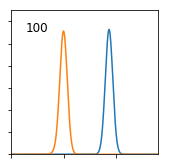

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
import scipy.integrate as intg
%matplotlib inline

# COmment on distinguishability of particles
# Check boundary conditions once more
# Check application of potential

def tdse(u_2, u_1, v_2, v_1, m1, m2, dt, dx, T_array, V, title):
    
    # initialization
    L = u_1.shape[0]
    M = u_1.shape[1]
    N = int(T_array.max())
    lmbd = dt/(dx**2)
    
    u = u_1
    v = v_1
    mzeros = np.zeros(M)
    lzeros = np.zeros(L)
    
    xs = np.arange(L)*dx
    la = xs.copy()
    ma = np.arange(M)*dx
    la, ma = np.meshgrid(la, ma)
    Va = V(la, ma) # think V0*exp(-np.abs(la-ma)/(2*alpha**2))
    
    fm = (((1/m1)+(1/m2))*4*lmbd + dt*Va)[1:-1,1:-1]
    
    splts = int(np.sqrt(T_array.size))
    fig = plt.figure(figsize = (splts*3,splts*3))
    tmp = 1
    
    # main loop
    for n in range(N+1):
        u[1:-1,1:-1] = u_2[1:-1,1:-1] + 2*(fm*v_1[1:-1,1:-1]
                    - lmbd *((v_1[2:,1:-1]
                            +v_1[:-2,1:-1])/m1
                            +(v_1[1:-1,2:]
                            +v_1[1:-1,:-2])/m2))
        u[0,:] = mzeros
        u[-1,:] = mzeros
        u[:,0] = lzeros
        u[:,-1] = lzeros
        v[1:-1,1:-1] = v_2[1:-1,1:-1] - 2*(fm*u_1[1:-1,1:-1]
                    - lmbd *((u_1[2:,1:-1]
                              +u_1[:-2,1:-1])/m1
                              +(u_1[1:-1,2:]
                              +u_1[1:-1,:-2])/m2))
        v[0,:] = mzeros
        v[-1,:] = mzeros
        v[:,0] = lzeros
        v[:,-1] = lzeros
        u_2 = u_1
        v_2 = v_1
        u_1 = u
        v_1 = v
        
        if n in T_array:
            rho = u*u_1 + v**2
            rho1 = intg.simps(rho, dx = dx, axis = 1)
            rho2 = intg.simps(rho, dx = dx, axis = 0)
            norm = intg.simps(rho1, dx = dx)
            
            ax = plt.subplot(splts,splts,tmp)
            tmp +=1
            ax.plot(xs, rho1/norm)
            ax.plot(xs, rho2/norm)
            ax.set_xlim(0,xs.max())
            ax.set_ylim(0,13)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.1,0.85, str(n), transform=ax.transAxes, fontsize=12)

    
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle(title,fontsize=20)
    plt.show()
    return

'''
    Trial run
'''
dx = 0.001
dt = 2.5e-7
m2 = .5
m1 = 5.

x01 = .467
x02 = .934
k1 = 157.
k2 = -157.
sgm = 0.05
L = 1.401
l = int(L/dx)
xs = np.arange(l)*dx
x1,x2 = np.meshgrid(xs,xs)
ef = np.exp(-((x1-x01)**2+(x2-x02)**2)/(2*sgm**2))
u0 = np.cos(k1*x1+k2*x2)*ef
v0 = np.sin(k1*x1+k2*x2 - (k1**2/(2*m1)+(k2**2/(2*m2)))*(dt/2))*ef

u0[0,:] = np.zeros(l)
u0[-1,:] = np.zeros(l)
u0[:,0] = np.zeros(l)
u0[:,-1] = np.zeros(l)
v0[0,:] = np.zeros(l)
v0[-1,:] = np.zeros(l)
v0[:,0] = np.zeros(l)
v0[:,-1] = np.zeros(l)


V0 = 100000./2.
alpha = 0.062
V_gauss = lambda x1, x2: V0*np.exp(-((x1-x2)**2)/(2*(alpha**2)))
V_square = lambda x1, x2: V0*np.heaviside(alpha-np.abs(x1-x2),1)

#%lprun -f tdse tdse(u0, v0, m1, m2, dt, dx, 100*dt, V)
#%prun tdse(u0, v0, m1, m2, dt, dx, 100*dt, V)

u_1, u, v_1, v = u0, u0, v0, v0
#T_array = np.array([1,850,950,1200,1400,1600,2200,2400,3000])
T_array = np.array([1,10,20,30])*100
#T_array = np.array([1,18,22,26,36,40,55,86,150])*100
tdse(u_1, u, v_1, v, m1, m2, dt, dx, T_array, V_square,'m-10m, Repulsive Vsquare')
    

In [ ]:
'''
t = 0
T_array = np.array([1,850,950,1200,1400,1600,2200,2400,3000])


fig = plt.figure(figsize = (9,9))

#for T in np.array([1.])*100*dt:
#for T in ((np.arange(7200)+1)*dt):
for i,T in enumerate(T_array*dt):
    t = T - t
    rho1, rho2, u_1, u, v_1, v = tdse(u_1, u, v_1, v, m1, m2, dt, dx, t, V_square)
    #plt.clf()
    ax = plt.subplot(331+i)
    ax.plot(xs, rho1, label='1st particle')
    ax.plot(xs, rho2, label='2nd particle')
    #plt.legend(loc = 'best')
    ax.set_xlim(0,L)
    ax.set_ylim(0,13)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.text(0.1,0.85, str(T_array[i]), transform=ax.transAxes, fontsize=12)
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
fig.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('m-10m, Repulsive Vsquare',fontsize=20)
plt.show()

for T in ((np.arange(7200)+1)*dt):
    t = T - t
    rho1, rho2, u_1, u, v_1, v = tdse(u_1, u, v_1, v, m1, m2, dt, dx, t, V_square)
    plt.clf()
    plt.plot(xs, rho1, label='1st particle')
    plt.plot(xs, rho2, label='2nd particle')
    plt.xlim(0,L)
    plt.ylim(0,13)
    plt.text(0.1,0.85, str(T/dt), fontsize=12)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    #if T//dt > 50: time.sleep(1.)
plt.show()
'''